# Pleiades Work-Precision Diagrams

https://benchmarks.sciml.ai/html/NonStiffODE/Pleiades_wpd.html

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools
using IRKGaussLegendre
using Plots,LinearAlgebra
using Dates

┌ Info: Precompiling IRKGaussLegendre [58bc7355-f626-4c51-96f2-1f8a038f95a2]
└ @ Base loading.jl:1273


## Initial value problem: Pleiades

In [2]:
f = (du,u,p,t) -> begin
  @inbounds begin
  x = view(u,1:7)   # x
  y = view(u,8:14)  # y
  v = view(u,15:21) # x′
  w = view(u,22:28) # y′
  du[1:7] .= v
  du[8:14].= w
  for i in 15:28
    du[i] = zero(u[1])
  end
  for i=1:7,j=1:7
    if i != j
      r = ((x[i]-x[j])^2 + (y[i] - y[j])^2)^(3/2)
      du[14+i] += j*(x[j] - x[i])/r
      du[21+i] += j*(y[j] - y[i])/r
    end
  end
  end
end

prob = ODEProblem(f,[3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0],
                 (0.0,3.0));


In [3]:
setprecision(BigFloat, 256)
prob128 = ODEProblem(f,BigFloat.([3.0,3.0,-1.0,-3.0,2.0,-2.0,2.0,
                     3.0,-3.0,2.0,0,0,-4.0,4.0,    
                     0,0,0,0,0,1.75,-1.5,
                     0,0,0,-1.25,1,0,0]),
                     (BigFloat(0.0),BigFloat(3.0)));
(typeof(prob128.u0),typeof(prob128.tspan))


(Array{BigFloat,1}, Tuple{BigFloat,BigFloat})

## Vern9

In [28]:
sol = @time (solve(prob128,Vern9(),abstol=1/10^20,reltol=1/10^20))
test_sol = TestSolution(sol);

 21.636795 seconds (57.21 M allocations: 2.821 GiB, 5.92% gc time)


In [29]:
plot(sol)

## Integration with IRKGL16 (Adaptive-step)

In [6]:
(sol1,iters1,steps1) = @time(solve(prob,IRKGL16(), reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

 10.240227 seconds (13.94 M allocations: 663.317 MiB, 4.66% gc time)


In [7]:
sum(iters1)/sol1.destats.naccept

10.10204081632653

In [8]:
sol1.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  8802
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          98
Number of rejected steps:                          19

## Integration with IRKGL162 (Adaptive-step)

In [9]:
(sol2,iters2,steps2) = @time(solve(prob,IRKGL162(), reltol=1e-12, abstol=1e-12,
                                   adaptive=true,myoutputs=true));

  1.649108 seconds (1.59 M allocations: 74.264 MiB)


In [10]:
sum(iters2)/sol2.destats.naccept

11.795918367346939

In [11]:
sol2.destats

DiffEqBase.DEStats
Number of function 1 evaluations:                  9383
Number of function 2 evaluations:                  0
Number of W matrix evaluations:                    0
Number of linear solves:                           0
Number of Jacobians created:                       0
Number of nonlinear solver iterations:             0
Number of nonlinear solver convergence failures:   0
Number of rootfind condition calls:                0
Number of accepted steps:                          98
Number of rejected steps:                          19

### Plots IRKGL16

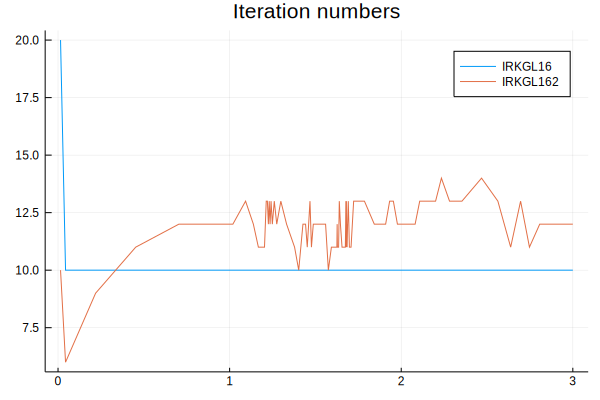

In [12]:
plot(sol1.t[2:end],iters1[2:end], title="Iteration numbers", label="IRKGL16")
plot!(sol2.t[2:end],iters2[2:end],label="IRKGL162")

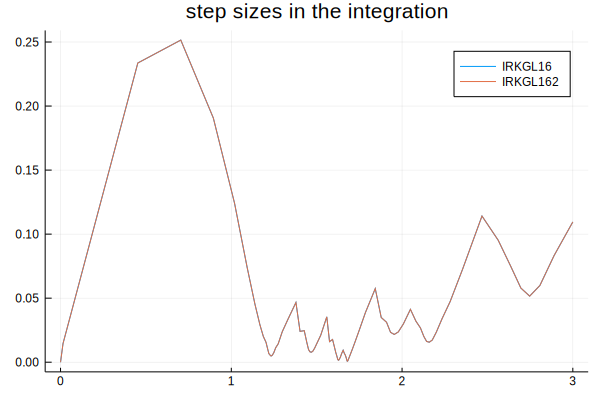

In [13]:
plot(sol1.t,steps1, title="step sizes in the integration", label="IRKGL16")
plot!(sol2.t,steps2,label="IRKGL162")

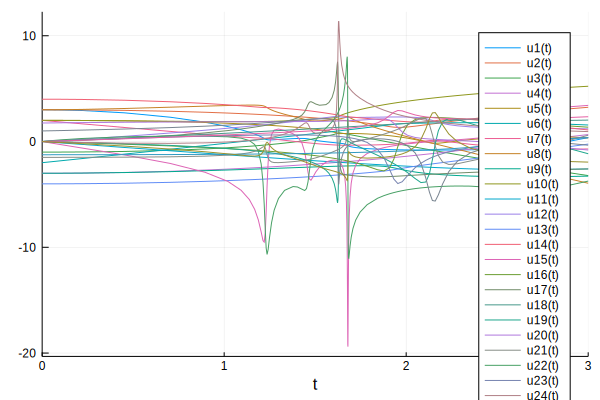

In [14]:
plot(sol1)

## Energy Error

In [30]:
u0128=prob128.u0
Gm128=BigFloat.([1,2,3,4,5,6,7])
(typeof(u0128),typeof(Gm128),length(Gm128))

(Array{BigFloat,1}, Array{BigFloat,1}, 7)

In [31]:
function NbodyEnergy(u, Gm)
"""    
     Nbody problem Hamiltonian (Cartesian Coordinates)     
"""    
    
    # Declarations 
    
    dim=2   
    nbody=length(Gm)
    
    # Implementation

 @inbounds begin
    x = view(u,1:7)   # x
    y = view(u,8:14)  # y
    v = view(u,15:21) # x′
    w = view(u,22:28) # y′
   
    H=0.
    P=0.
    
    for i in 1:nbody
        H+=Gm[i]*(v[i]*v[i]+w[i]*w[i])                       
        for j in i+1:nbody           
            r = ((x[i]-x[j])^2+(y[i]-y[j])^2)^(1/2)
            P+=(Gm[i]/r)*Gm[j]
        end
    end
    
    return(H/2-P)
    end
        
end

NbodyEnergy (generic function with 1 method)

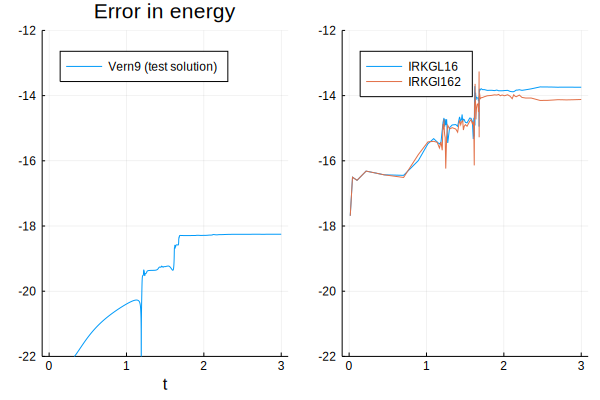

In [32]:
E0=NbodyEnergy(u0128,Gm128)
end1=length(steps1)

ulist = sol.u
tlist = sol.t
EnergyErrors=[NbodyEnergy(BigFloat.(sol.u[j]),Gm128)/E0-1 for j in 1:length(tlist)]

ulist1 = sol1.u[1:end]
tlist1 = sol1.t[1:end]
EnergyErrors1=[NbodyEnergy(BigFloat.(sol1.u[j]),Gm128)/E0-1 for j in 1:length(tlist1)]

ulist2 = sol2.u[1:end]
tlist2 = sol2.t[1:end]
EnergyErrors2=[NbodyEnergy(BigFloat.(sol2.u[j]),Gm128)/E0-1 for j in 1:length(tlist2)]

ylimit1=-22
ylimit2=-12

p1=plot(tlist[1:end],log10.(abs.(EnergyErrors)),
    ylims=(ylimit1,ylimit2),
   xlabel="t", title="Error in energy", label="Vern9 (test solution)", legend=:topleft)
p2=plot(tlist1[1:end],log10.(abs.(EnergyErrors1)),
        ylims=(ylimit1,ylimit2),
    label="IRKGL16", legend=:topleft)
p2=plot!(tlist2[1:end],log10.(abs.(EnergyErrors2)),
        ylims=(ylimit1,ylimit2),
        label="IRKGl162")
plot(p1,p2,layout=2)

In [33]:
(Float32(maximum(abs.(EnergyErrors))),Float32(maximum(abs.(EnergyErrors1))),Float32(maximum(abs.(EnergyErrors2))))

(5.5924663f-19, 1.9560877f-14, 5.4979452f-14)

## Global error

In [19]:
# IRGL16
apr = appxtrue(sol1,test_sol)
#@show sol1[end]
#@show apr.u[end]
@show apr.errors

apr.errors = Dict(:l∞ => 9.390892294919635900076852701838023431128344829608889191393521320267033905199724e-12,:L2 => 0.009701488879769370214755007447086122468937013821595892448512763495770567536999556,:final => 3.690838825544351875802893310452472102638577551949406296763892452881923116406098e-14,:l2 => 3.677460310859097364525987667864914119706257124322500576844713937172490795064489e-13,:L∞ => 0.1054979098456151133177496826487597868881928037236055922680099489648917069109444)


Dict{Symbol,BigFloat} with 5 entries:
  :l∞    => 9.39089e-12
  :L2    => 0.00970149
  :final => 3.69084e-14
  :l2    => 3.67746e-13
  :L∞    => 0.105498

In [20]:
err1=Float32(norm(sol1.u[end]-sol.u[end]))
err2=Float32(norm(sol2.u[end]-sol.u[end]))
(err1,err2)

(3.211812f-13, 6.948551f-13)

## High Order


In [21]:
now()

2020-04-20T08:26:16.562

In [22]:
abstols = 1.0 ./ 10.0 .^ (8:16)
reltols = 1.0 ./ 10.0 .^ (8:16);

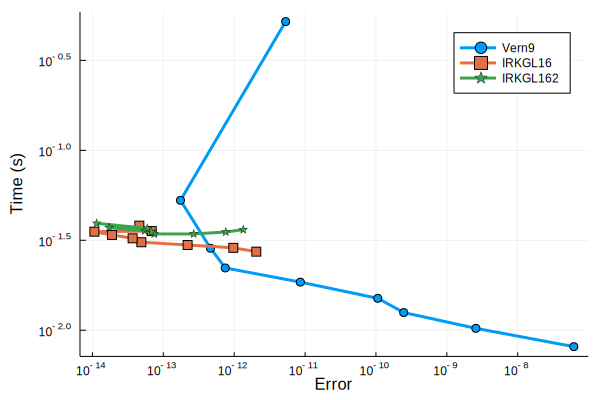

In [23]:
setups = [
#    Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16())
          Dict(:alg=>IRKGL162())
]
wp = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100,maxiters=100000)
plot(wp)

In [24]:
now()

2020-04-20T08:29:27.69

In [25]:
fieldnames(typeof(wp))

(:wps, :N, :abstols, :reltols, :prob, :setups, :names, :error_estimate, :numruns)

In [26]:
wp.wps

3-element Array{WorkPrecision,1}:
 Name: Vern9
Times: [0.008104229, 0.010244787, 0.01254155, 0.015041821, 0.018510416, 0.022185143, 0.028551396, 0.052734717, 0.519672579]
Errors: [6.185112457223087e-8, 2.566893911142516e-9, 2.4618427209374537e-10, 1.0606496779519642e-10, 8.570155389698514e-12, 7.484166204596721e-13, 4.630901868278207e-13, 1.7473935495224604e-13, 5.316832743279198e-12]
        
 Name: IRKGL16
Times: [0.027337023, 0.028707227, 0.029773019, 0.030844082, 0.032424363, 0.033864994, 0.035298477, 0.035586478, 0.038130206]
Errors: [2.0497727155841797e-12, 9.72050743598614e-13, 2.2016395476865564e-13, 4.897016840154968e-14, 3.690838825544352e-14, 1.886502079146125e-14, 1.0651535490612743e-14, 6.873967818469412e-14, 4.5896374498643233e-14]
   
 Name: IRKGL162
Times: [0.036230487, 0.035159212, 0.034300403, 0.034275893, 0.035160238, 0.035669502, 0.037208446, 0.036813005, 0.039284603]
Errors: [1.3440440203940361e-12, 7.612659809385086e-13, 2.6850061892860424e-13, 7.461662062734055e-

## Global Error2

In [37]:
#
#  Gerhard Wanner's reference solution 
#
x1 = parse(BigFloat,"0.370613914397051290093")
x2 = parse(BigFloat,"3.237284092057233092803")
x3 = parse(BigFloat,"-3.222559032418323347100")
x4 = parse(BigFloat,"0.6597091455775308359349")
x5 = parse(BigFloat,"0.3425581707156579790377")
x6 = parse(BigFloat,"1.562172101400631016045")
x7 = parse(BigFloat,"-0.7003092922212495385147")

y1 = parse(BigFloat,"-3.943437585517392055277")
y2 = parse(BigFloat,"-3.271380973972549928020")
y3 = parse(BigFloat,"5.225081843456544192438")
y4 = parse(BigFloat,"-2.590612434977469510811")
y5 = parse(BigFloat,"1.198213693392274637514")
y6 = parse(BigFloat,"-0.2429682344935823409161")
y7 = parse(BigFloat,"1.091449240428979747882")

v1 = parse(BigFloat,"3.417003806314314752291")
v2 = parse(BigFloat,"1.354584501625501221476")
v3 = parse(BigFloat,"-2.590065597810775419618")
v4 = parse(BigFloat,"2.025053734714241106485")
v5 = parse(BigFloat,"-1.155815100160449092711")
v6 = parse(BigFloat,"-0.8072988170223021725659")
v7 = parse(BigFloat,"0.5952396354208718766607")
                
w1 = parse(BigFloat,"-3.741244961234008471204")
w2 = parse(BigFloat,"0.3773459685750629036558")
w3 = parse(BigFloat,"0.9386858869551078886946")
w4 = parse(BigFloat,"0.3667922227200569866696")
w5 = parse(BigFloat,"-0.3474046353808494366007")
w6 = parse(BigFloat,"2.344915448180936923142")
w7 = parse(BigFloat,"-1.947020434263291900674") 

uu=[x1,x2,x3,x4,x5,x6,x7,
    y1,y2,y3,y4,y5,y6,y7,
    v1,v2,v3,v4,v5,v6,v7,
    w1,w2,w3,w4,w5,w6,w7
];

In [40]:
yest_sol2=TestSolution((BigFloat(0.0),BigFloat(3.0)),uu);

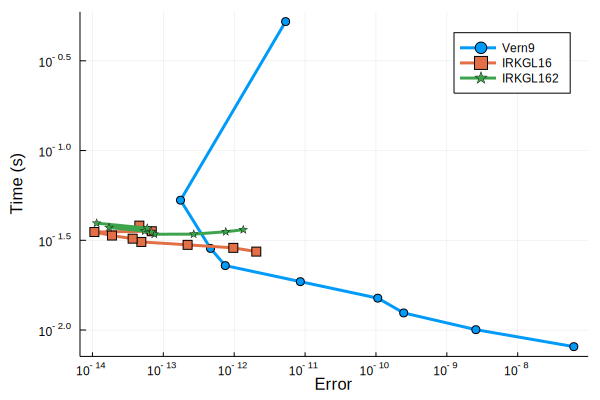

In [41]:
setups = [
#    Dict(:alg=>DP8())
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16())
          Dict(:alg=>IRKGL162())
]
wp2 = WorkPrecisionSet(prob,abstols,reltols,setups;appxsol=test_sol,save_everystep=false,numruns=100,maxiters=100000)
plot(wp2)

In [42]:
wp2.wps

3-element Array{WorkPrecision,1}:
 Name: Vern9
Times: [0.008078905, 0.010046194, 0.01245064, 0.015049589, 0.018603185, 0.022858212, 0.028497995, 0.052905384, 0.523287128]
Errors: [6.185112457256074e-8, 2.5668939113118004e-9, 2.461842717719343e-10, 1.0606496727810889e-10, 8.570154836624274e-12, 7.484164350371757e-13, 4.630902733441444e-13, 1.7473908701203112e-13, 5.316832865440706e-12]
      
 Name: IRKGL16
Times: [0.027351536, 0.028699189, 0.02982562, 0.030960354, 0.032289069, 0.033605565, 0.035164946, 0.035522974, 0.038171972]
Errors: [2.0497725053032616e-12, 9.720503632966172e-13, 2.2016374263604397e-13, 4.8969628288550725e-14, 3.690784814244456e-14, 1.886448067338162e-14, 1.0651408805529539e-14, 6.874006479276507e-14, 4.589673064039235e-14]
 
 Name: IRKGL162
Times: [0.036221816, 0.035276099, 0.034221904, 0.034178204, 0.035187358, 0.035574453, 0.037237966, 0.036958873, 0.039389866]
Errors: [1.3440438593407327e-12, 7.61265600636512e-13, 2.6850043468331543e-13, 7.461607748008055e-14, 6